<a href="https://colab.research.google.com/github/REIGEN06/Data-driven-management/blob/main/%D0%A2%D0%BE%D0%BA%D1%81%D0%B8%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import json

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from tqdm import tqdm

In [3]:
df = pd.read_csv('labeled.csv')

In [4]:
df['toxic'] = df['toxic'].apply(lambda x: 'Toxic' if x==1.0 else 'Not Toxic')

In [5]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",Toxic
1,"Хохлы, это отдушина затюканого россиянина, мол...",Toxic
2,Собаке - собачья смерть\n,Toxic
3,"Страницу обнови, дебил. Это тоже не оскорблени...",Toxic
4,"тебя не убедил 6-страничный пдф в том, что Скр...",Toxic
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,Toxic
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,Toxic
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",Not Toxic
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,Toxic


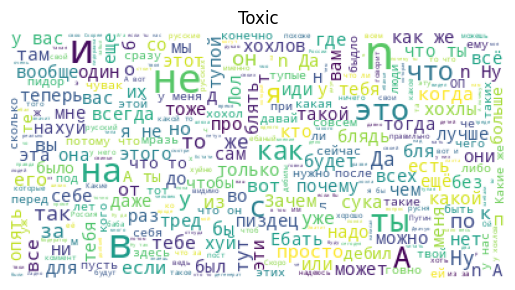

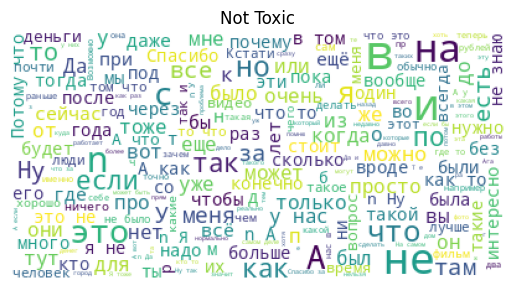

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# generate word cloud and show it
for x in df.toxic.unique():
    wc = WordCloud(background_color="white", max_words=2000,
                   max_font_size=40, random_state=42)
    wc.generate(df.comment[(df.comment.notnull()) & (df.toxic == x)].to_string())
    plt.imshow(wc)
    plt.title(x)
    plt.axis("off")
    plt.show()

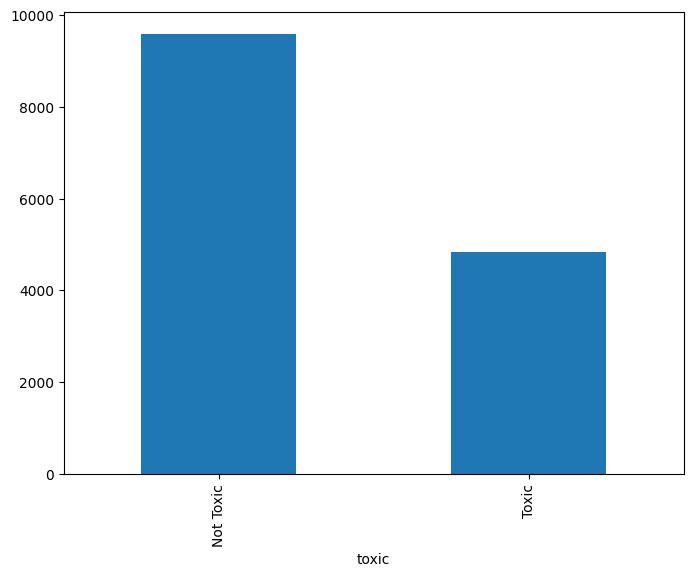

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('toxic').comment.count().plot.bar(ylim=0)
plt.show()

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_df(df):
    df = df.str.lower()
    df = df.replace(r'[^а-яА-Я]', ' ', regex=True)
    df = df.str.strip()
    df = df.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords.words('russian') and len(word)>2]))
    return df

df['comment'] = clean_df(df['comment'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Здесь я подготовил небольшую функцию для очистки данных. Прежде всего, мы будем регулярно удалять все знаки, кроме кириллицы. Во-вторых, мы удалим стоп-слова и слова длиной менее 2 символов, потому что такие слова не будут играть большой роли.

In [10]:
from collections import Counter

top = Counter([item for item in ''.join(df['comment'].values).split()])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,это,3383
1,просто,920
2,очень,581
3,вообще,561
4,лет,546
5,которые,433
6,время,420
7,года,379
8,хотя,342
9,нужно,337


In [12]:
df['category_id'] = df['toxic'].factorize()[0]
category_id_df = df[['toxic', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'toxic']].values)

# New dataframe
df = df.sample(frac=0.2)

In [20]:
#import pymorphy2
!pip install pymorphy2
import pymorphy2
df = df.dropna(subset=['comment'])
morph = pymorphy2.MorphAnalyzer()

def lem_tok(text):
    text_lem = [morph.parse(word)[0].normal_form for word in text.split(' ')]
    return text_lem

Для лемматизации текстов я буду использовать библиотеку российских разработчиков pymorphy2.

Что такое лемматизация? Это приведение слова к исходной форме. Например: люди->человек

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), tokenizer=lem_tok)
features = tfidf.fit_transform(df.comment).toarray()
labels = df.category_id
features.shape


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(576, 253)

In [23]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[category_id])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Not Toxic':
  . Most correlated unigrams:
. вид
. выйти
  . Most correlated bigrams:
. сей пора
. пара день
# 'Toxic':
  . Most correlated unigrams:
. хохол
. блядь
  . Most correlated bigrams:
. сам дело
. год назад


In [25]:
%%time
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[category_id])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(category))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-5:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-5:])))


==> Not Toxic:
  * Most Correlated Unigrams are: доход, пойти, слишком, вид, выйти
  * Most Correlated Bigrams are: год назад, сам дело, сей пора, пара день

==> Toxic:
  * Most Correlated Unigrams are: ебал, тупой, тред, хохол, блядь
  * Most Correlated Bigrams are: пара день, сей пора, сам дело, год назад
CPU times: user 20.5 ms, sys: 13.1 ms, total: 33.6 ms
Wall time: 52.2 ms


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


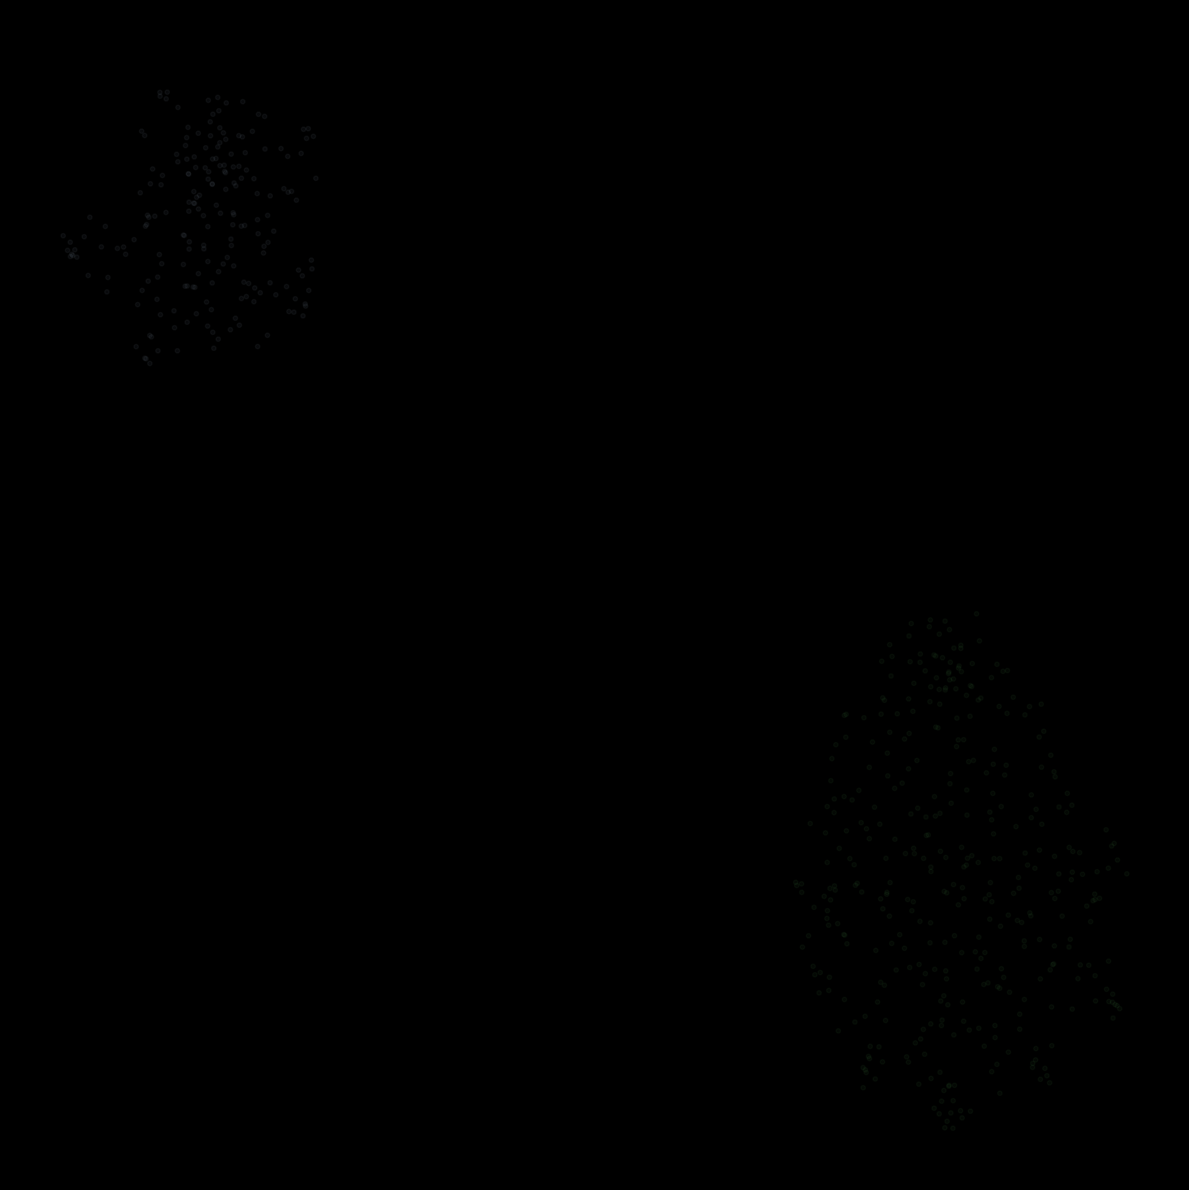

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())
!pip3 install umap-learn
from umap import UMAP

tfidf = TfidfVectorizer()

train = df#.sample(10000)
docs = tfidf.fit_transform(train['comment'])
target = train['category_id']

umap = UMAP(random_state=0)
dr = umap.fit_transform(docs, target)

colors = [colors_list[i] for i in target]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.axis('off')

ax.scatter(x=dr[:,0], y=dr[:,1], s=10, alpha=0.05, c = colors,)
ax.set_title('TFIDF Dimension Reduction', loc='left', fontsize=20, fontweight='bold')
fig.patch.set_facecolor('black')
fig.tight_layout()
plt.show()

In [31]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in tqdm(models):
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in tqdm(enumerate(accuracies)):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df.groupby('model_name').mean()

  0%|          | 0/3 [00:00<?, ?it/s]
5it [00:00, 31583.61it/s]
 33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]
5it [00:00, 34492.63it/s]
 67%|██████▋   | 2/3 [00:00<00:00,  5.20it/s]
5it [00:00, 8227.35it/s]
100%|██████████| 3/3 [00:00<00:00,  3.29it/s]

CPU times: user 306 ms, sys: 144 ms, total: 450 ms
Wall time: 973 ms


,fold_idx,accuracy
model_name,,
LinearSVC,2.0,0.699685
LogisticRegression,2.0,0.725682
MultinomialNB,2.0,0.727451


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(C=np.arange(0.3, 1.6, 0.3),penalty=['l2', 'l1'])

logreg = Pipeline([
    ('tfidf',TfidfVectorizer(sublinear_tf=True, min_df=10,
                        ngram_range=(1, 2),
                        tokenizer=lem_tok) ),
    ('clf',RandomizedSearchCV(LogisticRegression(), distributions, random_state=0))
])

In [52]:
X = df['comment']
y = df['category_id']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,test_size=0.5,stratify=y)

In [53]:
logreg.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=10, ngram_range=(1, 2),
                                 sublinear_tf=True,
                                 tokenizer=<function lem_tok at 0x7d7b7fc13370>)),
                ('clf',
                 RandomizedSearchCV(estimator=LogisticRegression(),
                                    param_distributions={'C': array([0.3, 0.6, 0.9, 1.2, 1.5]),
                                                         'penalty': ['l2',
                                                                     'l1']},
                                    random_state=0))])

In [54]:
y_pred = logreg.predict(X_test)

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print(classification_report(y_test, y_pred, target_names=category_to_id))
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

              precision    recall  f1-score   support

       Toxic       0.58      0.11      0.19        99
   Not Toxic       0.67      0.96      0.79       189

    accuracy                           0.67       288
   macro avg       0.63      0.53      0.49       288
weighted avg       0.64      0.67      0.58       288

F1 Score: 0.5827843978980091


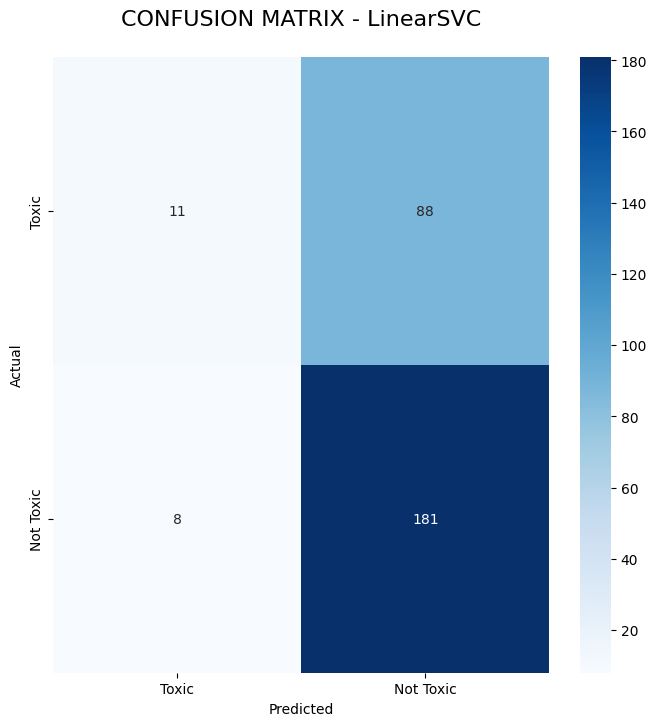

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.toxic.values,
            yticklabels=category_id_df.toxic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [57]:
text_input = 'кого любить идиотина сука? Гоблина тупорылого что-ли? '

category_id_df[category_id_df['category_id'] == logreg.predict(
    [text_input])[0]]['toxic'].values[0]

'Not Toxic'

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'